## Read the data

In [241]:
import pandas as pd

df = pd.read_csv('madrid_rent_data_clustered.csv')

# Keep only Cluster N if specified
CLUSTERS_TO_ANALYZE: list[int] | None = [1]
if CLUSTERS_TO_ANALYZE is not None:
    df = df[df['Cluster'].isin(CLUSTERS_TO_ANALYZE)]
df_original = df.__deepcopy__()

df.head()

,Id,District,Address,Number,Area,Rent,Bedrooms,Sq.Mt,Floor,Outer,Elevator,Penthouse,Cottage,Duplex,Semidetached,Cluster
308,390,Moncloa,Piso en calle Doctor Juan José López Ibor,NaN,Ciudad Universitaria,1150,2.0,106,5.0,1.0,1.0,0,0,0,0,1
309,391,Moncloa,Piso en Martin de los heros,NaN,Argüelles,850,1.0,60,0.5,1.0,0.0,0,0,0,0,1
312,394,Moncloa,Piso en calle Juan Átlvarez Mendizábal,61,Argüelles,1050,1.0,53,5.0,1.0,1.0,0,0,0,0,1
314,396,Moncloa,Piso en calle de Sánchez Preciado,15,Valdezarza,1375,3.0,106,2.0,1.0,1.0,0,0,0,0,1
315,397,Moncloa,Piso en avenida Europa,NaN,Aravaca,1400,2.0,110,3.0,1.0,1.0,0,0,0,0,1


## Remove unneeded columns

In [242]:
df = df.drop(columns=['Number', 'Id', 'Address', 'Area', 'Cluster'])

## Fill missing values

In [243]:
df.isnull().sum()

District         0
Rent             0
Bedrooms        42
Sq.Mt            0
Floor            5
Outer            9
Elevator         4
Penthouse        0
Cottage          0
Duplex           0
Semidetached     0
dtype: int64

In [244]:
df['Bedrooms'] = df['Bedrooms'].fillna(df['Bedrooms'].mean())
df['Floor'] = df['Floor'].fillna(0)
df['Outer'] = df['Outer'].fillna(0.5)
df['Elevator'] = df['Elevator'].fillna(0.5)

In [245]:
df.isnull().sum()

District        0
Rent            0
Bedrooms        0
Sq.Mt           0
Floor           0
Outer           0
Elevator        0
Penthouse       0
Cottage         0
Duplex          0
Semidetached    0
dtype: int64

## Histogram of the target variable

[Text(0.5, 1.0, 'Histogram of Rent variable')]

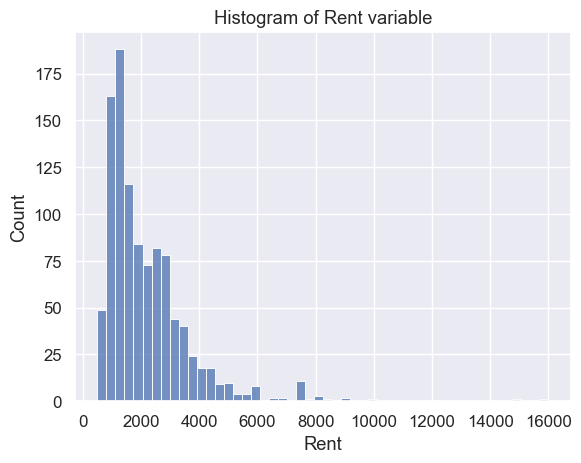

In [246]:
import seaborn as sns

target = "Rent"
sns.histplot(df[target]).set(title='Histogram of Rent variable')

## Split into train and test data

In [247]:
from sklearn.model_selection import train_test_split
import numpy as np

y = df.pop("Rent")
# y = np.log(y)
# y = np.sqrt(y)
x = df

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Apply feature engineering

In [248]:
def is_categorical(column):
    return column.dtype == 'object' or column.dtype == 'category'

def is_numerical(column):
    return column.dtype == 'float64' or column.dtype == 'int64'

In [249]:
# Find the categorical columns and numerical columns that we want to preprocess

categorical_columns = [f for f in x.columns if is_categorical(x[f])]

# We want to keep these numerical columns as they are
whitelist_numerical_columns = ['Outer', 'Elevator', 'Penthouse', 'Cottage', 'Duplex', 'Semidetached']  

numerical_columns = [f for f in x.columns if is_numerical(x[f]) and f not in whitelist_numerical_columns]

print(f"Categorical columns: {categorical_columns}")
print(f"Numerical columns: {numerical_columns}")

Categorical columns: ['District']
Numerical columns: ['Bedrooms', 'Sq.Mt', 'Floor']


In [250]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Create pipeline for categorical variables 
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])

# Create pipeline for numerical variables
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Combine both pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    [
        ('categorical', categorical_pipeline, categorical_columns),
        ('numerical', numerical_pipeline, numerical_columns)
    ], 
    remainder="passthrough"
)

In [251]:
x_train_preprocessed = preprocessor.fit_transform(x_train)
x_test_preprocessed = preprocessor.transform(x_test)

## Apply stepwise execution

In [252]:
import statsmodels.api as sm                    # Statistical analysis


# Stepwise function
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, # 95% confidence level
                       threshold_out = 0.1, # 90% confidence level - not the same to avoid infinite loops and give more stability
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        
        for new_col in excluded:
            model = sm.OLS(y, sm.add_constant(X[included+[new_col]])).fit()
            new_pval[new_col] = model.pvalues[new_col]

        if not new_pval.empty:
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed = True
                if verbose:
                    print(f"Add  {best_feature:30} with p-value {best_pval:.4g}")
                    
        # backward step
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        pvalues = model.pvalues.drop("const", errors="ignore")

        # use all coefs except intercept
        if not pvalues.empty:
                worst_pval = pvalues.max()
                if worst_pval > threshold_out:
                    worst_feature = pvalues.idxmax()      
                    included.remove(worst_feature)
                    changed = True
                    if verbose:
                        print(f"Drop {worst_feature:30} with p-value {worst_pval:.4g}")
        if not changed:
            break
            
    return included

In [253]:
x_train_preprocessed_df = pd.DataFrame(x_train_preprocessed, columns=preprocessor.get_feature_names_out())
# Reset index to match with y_train
x_train_preprocessed_df.index = y_train.index

x_train_preprocessed_df.head()

,categorical__District_Centro,categorical__District_Chamartín,categorical__District_Chamberí,categorical__District_Moncloa,categorical__District_Retiro,categorical__District_Salamanca,categorical__District_Tetuán,numerical__Bedrooms,numerical__Sq.Mt,numerical__Floor,remainder__Outer,remainder__Elevator,remainder__Penthouse,remainder__Cottage,remainder__Duplex,remainder__Semidetached
1567,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.453113,0.132828,0.407321,1.0,1.0,0.0,0.0,0.0,0.0
1028,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.142498,-0.834880,-0.507772,1.0,1.0,0.0,0.0,0.0,0.0
533,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.030557,-0.942403,-0.507772,1.0,1.0,0.0,0.0,0.0,0.0
1801,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.344692,-0.899394,-0.812803,1.0,0.0,0.0,0.0,0.0,0.0
878,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.453113,0.186590,-0.812803,1.0,1.0,0.0,0.0,0.0,0.0


In [254]:
result = stepwise_selection(x_train_preprocessed_df, y_train)
print('resulting features:')
print(result)

Add  numerical__Sq.Mt               with p-value 5.418e-248
Add  categorical__District_Salamanca with p-value 1.965e-16
Add  numerical__Floor               with p-value 2.418e-05
Add  categorical__District_Centro   with p-value 1.404e-05
Add  categorical__District_Chamberí with p-value 0.01034
Add  categorical__District_Retiro   with p-value 0.01172
Add  categorical__District_Chamartín with p-value 0.0371
Add  remainder__Duplex              with p-value 0.04782
resulting features:
['numerical__Sq.Mt', 'categorical__District_Salamanca', 'numerical__Floor', 'categorical__District_Centro', 'categorical__District_Chamberí', 'categorical__District_Retiro', 'categorical__District_Chamartín', 'remainder__Duplex']


In [255]:
for item in x_train_preprocessed_df.columns:
    if item not in result:
        x_train_preprocessed_df=x_train_preprocessed_df.drop(labels=[item],axis=1) #removes the non relevant variables

x_train_preprocessed_df.head()

,categorical__District_Centro,categorical__District_Chamartín,categorical__District_Chamberí,categorical__District_Retiro,categorical__District_Salamanca,numerical__Sq.Mt,numerical__Floor,remainder__Duplex
1567,0.0,0.0,1.0,0.0,0.0,0.132828,0.407321,0.0
1028,1.0,0.0,0.0,0.0,0.0,-0.834880,-0.507772,0.0
533,0.0,0.0,0.0,1.0,0.0,-0.942403,-0.507772,0.0
1801,0.0,0.0,0.0,0.0,0.0,-0.899394,-0.812803,0.0
878,0.0,0.0,0.0,0.0,1.0,0.186590,-0.812803,0.0


## Show the correlation matrix

<Axes: >

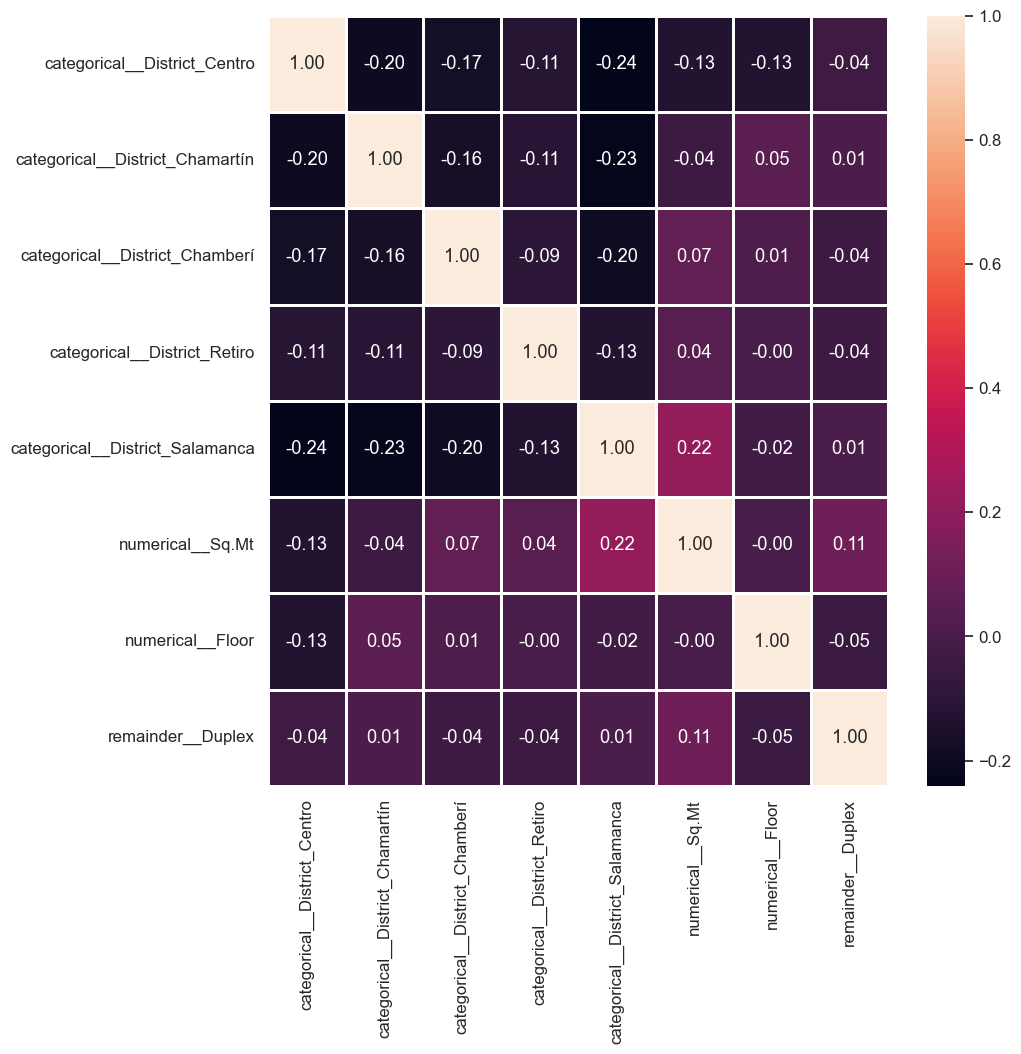

In [256]:
import matplotlib.pyplot as plt

sns.set(font_scale=1.1)
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(x_train_preprocessed_df.corr(), annot=True, fmt=".2f", linewidths=1, ax=ax)

## Create a linear regression model

In [257]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression(fit_intercept=True)
model=lm.fit(x_train_preprocessed_df, y_train)


In [258]:
# print coefficients (but not confidence intervals: sklearn does not store them)
coeff_df = pd.DataFrame(model.coef_,x_train_preprocessed_df.columns,columns=['Coefficient'])
print("Intercept: ", lm.intercept_)
coeff_df

Intercept:  1870.9005790781935


,Coefficient
categorical__District_Centro,392.943685
categorical__District_Chamartín,146.915221
categorical__District_Chamberí,267.586745
categorical__District_Retiro,305.957494
categorical__District_Salamanca,687.480885
numerical__Sq.Mt,1172.646967
numerical__Floor,114.768793
remainder__Duplex,-287.458716


## Get R squared value

In [259]:
print(f"R squared value is : {model.score(x_train_preprocessed_df,y_train):.3f}")

R squared value is : 0.781


## Create train predictions

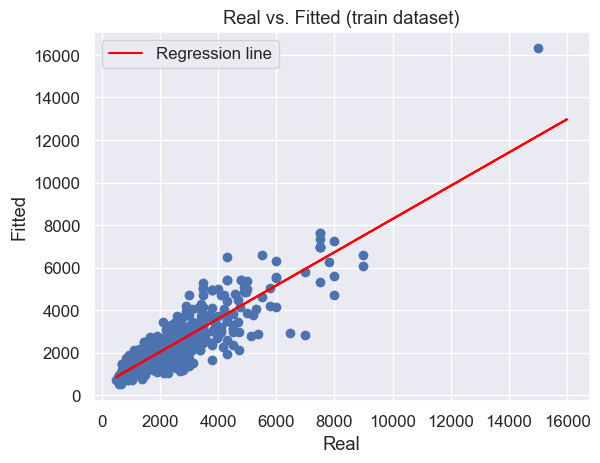

In [260]:
import numpy as np

predictions_train = lm.predict(x_train_preprocessed_df[x_train_preprocessed_df.columns]) #only with the columns used in the model

plt.title("Real vs. Fitted (train dataset)")
plt.scatter(y_train,predictions_train)

coef = np.polyfit(y_train, predictions_train, 1)  
poly1d_fn = np.poly1d(coef)  
plt.plot(y, poly1d_fn(y), color="red", label="Regression line")

plt.xlabel("Real")
plt.ylabel("Fitted")
plt.legend()
plt.show()

## Create test predictions

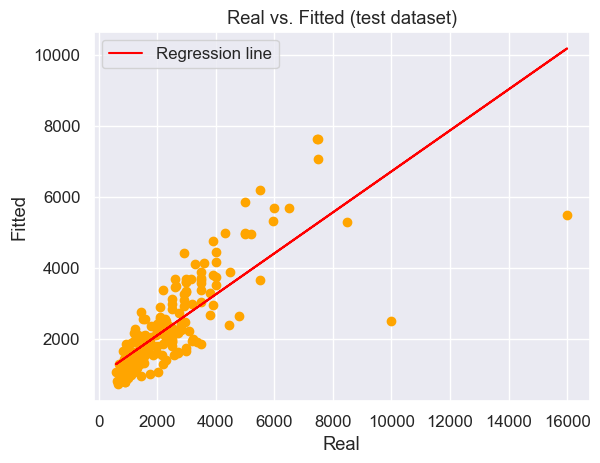

In [261]:
# test dataset
x_test_preprocessed_df = pd.DataFrame(x_test_preprocessed, columns=preprocessor.get_feature_names_out())
predictions_test = lm.predict(x_test_preprocessed_df[x_train_preprocessed_df.columns]) #only with the columns used in the model
plt.title("Real vs. Fitted (test dataset)")
plt.scatter(y_test,predictions_test, color="orange")

coef = np.polyfit(y_test, predictions_test, 1)  
poly1d_fn = np.poly1d(coef)  
plt.plot(y_test, poly1d_fn(y_test), color="red", label="Regression line")

plt.xlabel("Real")
plt.ylabel("Fitted")

plt.legend()
plt.show()

## Residual histograms

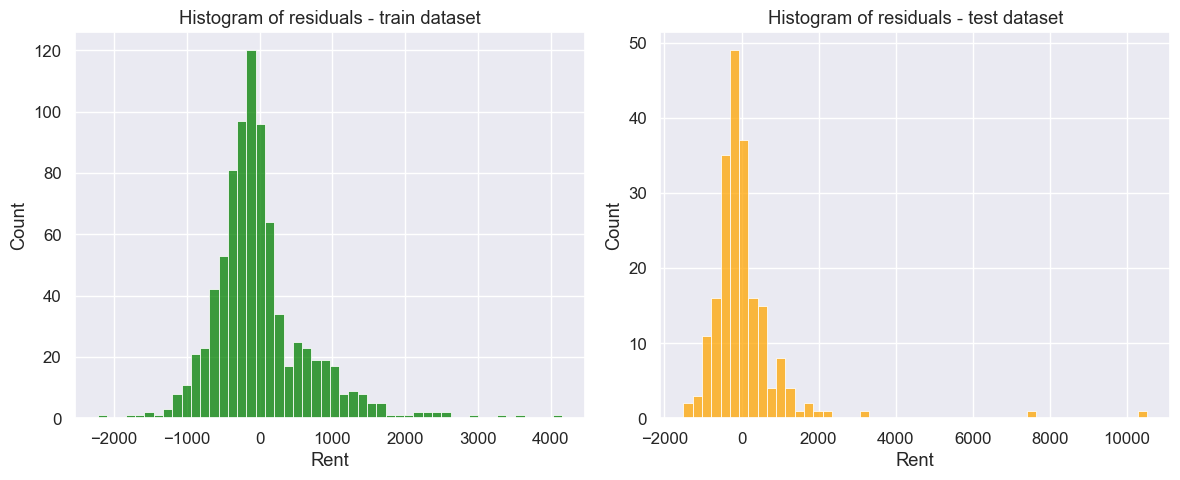

In [262]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot((y_train - predictions_train), bins=50, color="green", ax=axes[0])
axes[0].set_title("Histogram of residuals - train dataset")

sns.histplot((y_test - predictions_test), bins=50, color="orange", ax=axes[1])
axes[1].set_title("Histogram of residuals - test dataset")

plt.tight_layout()
plt.show()

## Get metrics

In [263]:
from sklearn import metrics

# error comparison between the two datasets
print ("Errors:\n")
results = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MAPE %'],
    'Train': [
        metrics.mean_absolute_error(y_train, predictions_train),
        metrics.mean_squared_error(y_train, predictions_train),
        np.sqrt(metrics.mean_squared_error(y_train, predictions_train)),
        np.mean(100 * abs(y_train - predictions_train) / y_train)
    ],
    'Test': [
        metrics.mean_absolute_error(y_test, predictions_test),
        metrics.mean_squared_error(y_test, predictions_test),
        np.sqrt(metrics.mean_squared_error(y_test, predictions_test)),
        np.mean(100 * abs(y_test - predictions_test) / y_test)
    ]
}

results_df = pd.DataFrame(results)
results_df

Errors:



,Metric,Train,Test
0,MAE,456.100694,5.361879e+02
1,MSE,434578.044682,1.196018e+06
2,RMSE,659.225337,1.093626e+03
3,MAPE %,22.645564,2.361964e+01


In [264]:
x_train_preprocessed_df = sm.add_constant(x_train_preprocessed_df) 
result = sm.OLS(y_train, x_train_preprocessed_df).fit()
print (result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Rent   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     366.6
Date:                Mon, 06 Oct 2025   Prob (F-statistic):          8.73e-265
Time:                        21:09:37   Log-Likelihood:                -6557.4
No. Observations:                 829   AIC:                         1.313e+04
Df Residuals:                     820   BIC:                         1.318e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     